# LangGraph Example

### Before you start this notbook. 
Create a .env files in same place you have placed this notebook and add following two keys. You can get the API keys from respective website.  
OPENAI_API_KEY=<<key>>  
TAVILY_API_KEY=<<key>>

In [1]:

import openai
import re
import httpx
import os
from dotenv import load_dotenv, dotenv_values
import certifi
import ssl
import json

ssl_context = ssl.create_default_context(cafile=certifi.where())
os.environ["SSL_CERT_FILE"] = certifi.where() # was getting a cert error with openAI. So had to do this.

_ = load_dotenv()
from openai import OpenAI

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
# for k,v in os.environ.items():
#     print(k,v)

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema.runnable import RunnableLambda
from pydantic import BaseModel
from langchain.tools import Tool

This is one of the tool we provide to the LangChain

In [5]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [7]:
class Agent:
    def __init__(self, model, tools, system=""):
        # initilal prompt
        self.system = system
        # Creating a state graph
        graph = StateGraph(AgentState)
        # adding a LLM node. Basically this calls the LLM 
        graph.add_node('llm',self.llm_action)
        # adding another node called action. 
        # Based on what LLM responds we will take further actions
        graph.add_node('action',self.take_action)

        # We are adding a conditional edge. If LLM is done with all tool_calls we just 
        # mark it END and retrun the final response to user.
        graph.add_conditional_edges(
            'llm',
            self.condition_check,
            {True: "action", False: END}
        )
        # We are connecting action node and LLM node in the graph
        graph.add_edge('action', 'llm')
        graph.set_entry_point('llm')

        self.graph = graph.compile()

        # all tools names given to the class
        self.tools = {t.name: t for t in tools}
        # looks like all model class will have bind_tools
        self.model = model.bind_tools(tools) 

    def condition_check(self, state: AgentState):
        message = state["messages"][-1]
        # tool_calls is what we get back from OpenAI
        return len(message.tool_calls) > 0

    def llm_action(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            # for every request you are adding a Prompt if present
            messages = [SystemMessage(content=self.system)] + messages
        
        # you are invoking LLM here
        message = self.model.invoke(messages)
        return {"messages":[message]}

    def take_action(self, state: AgentState):
        # check if there are any tool calls
        tool_calls = state['messages'][-1].tool_calls
        # results of the tool calls
        results = []
        for tool in tool_calls:
            if not tool['name'] in self.tools:
                # telling the LLM to Try again
                result = "bad tool try again"
            else:
                result = self.tools[tool['name']].invoke(tool['args'])
            tool_msg = ToolMessage(tool_call_id=tool['id'], name=tool['name'], content=str(result))
            results.append(tool_msg)
        print(f"Take action results:{results}")
        return {'messages':results}

In [8]:
def order_status(name):
    print(f"Pulling orders status for: {name}")
    if name in "1234599": 
        return(f"Order status for {name} at zip 28269 is ready for pickup")
    
    elif name in "123455":
        return("Order is in progress and will be delivered to 60502 soon")
    elif name in "123465":
        return(f"Order status for {name} at zip  is ready for pickup")
    elif name in "123459":
        return(f"Order status for {name} is ready to be delivered to 60502 soon")
    else:
        return("Unknown at this time.")



class OrderStatusInput(BaseModel):
    name: str

# Ensure the function correctly extracts the order ID
def order_status_handler(input):
    if isinstance(input, dict):  
        name = input.get("name", "")
    elif isinstance(input, OrderStatusInput):  
        name = input.name
    elif isinstance(input, str):  
        name = input
    else:  
        raise ValueError("Invalid input type for order_status")

    return order_status(name)  # Call the actual function

order_status_tool = Tool(
    name="order_status",
    func=order_status_handler,  
    description="Fetches the order status given an order ID.",
    args_schema=OrderStatusInput  
)


In [9]:
# MODEL = 'gpt-3.5-turbo'
# MODEL = 'o3-mini' 
MODEL = 'gpt-4o'

In [10]:
tool = TavilySearchResults(max_results=1) 
model = ChatOpenAI(model=MODEL)

In [11]:
# prompt = """You are a smart research assistant. Use the search engine to look up information. \
# You are allowed to make multiple calls (either together or in sequence). \
# Only look up information when you are sure of what you want. \
# If you need to look up some information before asking a follow up question, you are allowed to do that!
# If there is an order number then call order_status. If there is zip then call the tavily_search_results_json for latest weather info like what is the weather like for zip 60502. 
# Any other request just response it cannot be done politely.
# """
prompt = """You are retail ecom bot agent. You are capabale of giving order status info along with weather based on the order zip availability. 
Order Zip will be returned by order_status and not consider the zip code provided by users.
Any other request you get you politely says sorry and can't be processed

Your available function are:

order_status

tavily_search_results_json

For example:
User ask what is the stauts of my order number 123454

Tool responds with order status for 123454 at zip 60503 is ready for pick up

If you see a zip in tool response then make a call to tavily_search_results_json to get weather for 60502
And finally respond to user You order 123454 is ready for pick at 60503 and weaterh is sunny and good to pick it up

You then output:
Order status for 12345 at zip 60502 is ready for pickup and the weather details are...

If there is any missing information from the tool you just respond back with the last available information from the tool. 
"""

# model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool, order_status_tool], system=prompt)

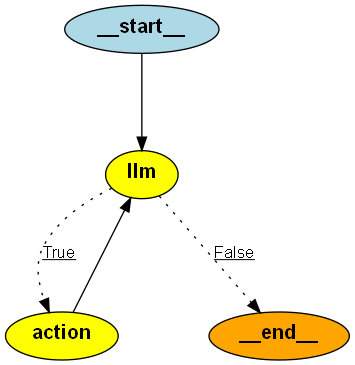

In [12]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [13]:
messages = [HumanMessage(content="What is the status of my order 1234599 ?")]
result = abot.graph.invoke({"messages": messages})

Pulling orders status for: 1234599
Take action results:[ToolMessage(content='Order status for 1234599 at zip 28269 is ready for pickup', name='order_status', tool_call_id='call_vLImS0TGB8jq7NL43xxahR77')]
Take action results:[ToolMessage(content='[{\'title\': \'Weather in 28269\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Charlotte\', \'region\': \'North Carolina\', \'country\': \'USA\', \'lat\': 35.2886009216309, \'lon\': -80.8208999633789, \'tz_id\': \'America/New_York\', \'localtime_epoch\': 1741920519, \'localtime\': \'2025-03-13 22:48\'}, \'current\': {\'last_updated_epoch\': 1741920300, \'last_updated\': \'2025-03-13 22:45\', \'temp_c\': 18.9, \'temp_f\': 66.0, \'is_day\': 0, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/116.png\', \'code\': 1003}, \'wind_mph\': 3.6, \'wind_kph\': 5.8, \'wind_degree\': 225, \'wind_dir\': \'SW\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.93, \'precip_m

In [14]:
result["messages"][-1].content

'Your order 1234599 is ready for pickup at zip 28269. The weather there is partly cloudy with a temperature of 66°F, making it a good time to pick up your order.'